## Importing Libraries

In [69]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
df = pd.read_csv('data/monatszahlen2412_verkehrsunfaelle_06_12_24.csv')

In [38]:
df.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
0,Alkoholunfälle,insgesamt,2024,202401,NaN,NaN,NaN,NaN,NaN
1,Alkoholunfälle,insgesamt,2024,202402,NaN,NaN,NaN,NaN,NaN
2,Alkoholunfälle,insgesamt,2024,202403,NaN,NaN,NaN,NaN,NaN
3,Alkoholunfälle,insgesamt,2024,202404,NaN,NaN,NaN,NaN,NaN
4,Alkoholunfälle,insgesamt,2024,202405,NaN,NaN,NaN,NaN,NaN


In [17]:
df.describe()

,JAHR,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
count,2254.000000,2086.000000,2086.000000,1924.000000,2001.000000,1932.000000
mean,2011.965839,1403.599712,1407.038830,5.321450,2.859020,775.825052
std,7.157922,4526.041109,4547.351874,40.627602,31.783479,1161.255368
min,2000.000000,0.000000,0.000000,-100.000000,-100.000000,12.000000
25%,2006.000000,41.000000,41.000000,-15.497500,-11.890000,40.000000
50%,2012.000000,394.000000,394.000000,0.000000,-0.650000,422.000000
75%,2018.000000,859.000000,859.750000,18.750000,11.110000,816.000000
max,2024.000000,46988.000000,46988.000000,600.000000,425.000000,3977.000000


## Filtering Data

In [39]:
unique_months = df["MONAT"].unique()
unique_months

array(['202401', '202402', '202403', '202404', '202405', '202406',
       '202407', '202408', '202409', '202410', '202411', '202412',
       '202301', '202302', '202303', '202304', '202305', '202306',
       '202307', '202308', '202309', '202310', '202311', '202312',
       'Summe', '202201', '202202', '202203', '202204', '202205',
       '202206', '202207', '202208', '202209', '202210', '202211',
       '202212', '202101', '202102', '202103', '202104', '202105',
       '202106', '202107', '202108', '202109', '202110', '202111',
       '202112', '202001', '202002', '202003', '202004', '202005',
       '202006', '202007', '202008', '202009', '202010', '202011',
       '202012', '201901', '201902', '201903', '201904', '201905',
       '201906', '201907', '201908', '201909', '201910', '201911',
       '201912', '201801', '201802', '201803', '201804', '201805',
       '201806', '201807', '201808', '201809', '201810', '201811',
       '201812', '201701', '201702', '201703', '201704', '20170

In [40]:
#non-integer months
non_integer_months = [month for month in unique_months if not month.isdigit()]
non_integer_months
# Remove non-integer months from the filtered dataframe
df = df[~df["MONAT"].isin(non_integer_months)]

#Convert strind data to int
df['JAHR'] = df['JAHR'].astype(int)
df['MONAT'] = df['MONAT'].astype(int)

df.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
0,Alkoholunfälle,insgesamt,2024,202401,NaN,NaN,NaN,NaN,NaN
1,Alkoholunfälle,insgesamt,2024,202402,NaN,NaN,NaN,NaN,NaN
2,Alkoholunfälle,insgesamt,2024,202403,NaN,NaN,NaN,NaN,NaN
3,Alkoholunfälle,insgesamt,2024,202404,NaN,NaN,NaN,NaN,NaN
4,Alkoholunfälle,insgesamt,2024,202405,NaN,NaN,NaN,NaN,NaN


In [41]:
df['MONAT'] = pd.to_datetime(df['MONAT'].astype(str), format='%Y%m')

In [42]:
df.set_index(df['MONAT'], inplace=True)
df.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
MONAT,,,,,,,,,
2024-01-01,Alkoholunfälle,insgesamt,2024,2024-01-01,NaN,NaN,NaN,NaN,NaN
2024-02-01,Alkoholunfälle,insgesamt,2024,2024-02-01,NaN,NaN,NaN,NaN,NaN
2024-03-01,Alkoholunfälle,insgesamt,2024,2024-03-01,NaN,NaN,NaN,NaN,NaN
2024-04-01,Alkoholunfälle,insgesamt,2024,2024-04-01,NaN,NaN,NaN,NaN,NaN
2024-05-01,Alkoholunfälle,insgesamt,2024,2024-05-01,NaN,NaN,NaN,NaN,NaN


In [43]:
df.drop('MONAT', axis=1, inplace=True)
pivot_Wert = df[df['JAHR']<=2020].pivot_table(index='MONAT', columns=['MONATSZAHL', 'AUSPRAEGUNG'], values='WERT')

In [44]:
pivot_Wert.columns = ['_'.join(col).strip() for col in pivot_Wert.columns.values]
pivot_Wert.columns

Index(['Alkoholunfälle_Verletzte und Getötete', 'Alkoholunfälle_insgesamt',
       'Fluchtunfälle_Verletzte und Getötete', 'Fluchtunfälle_insgesamt',
       'Verkehrsunfälle_Verletzte und Getötete', 'Verkehrsunfälle_insgesamt',
       'Verkehrsunfälle_mit Personenschäden'],
      dtype='object')

## Data Visualization

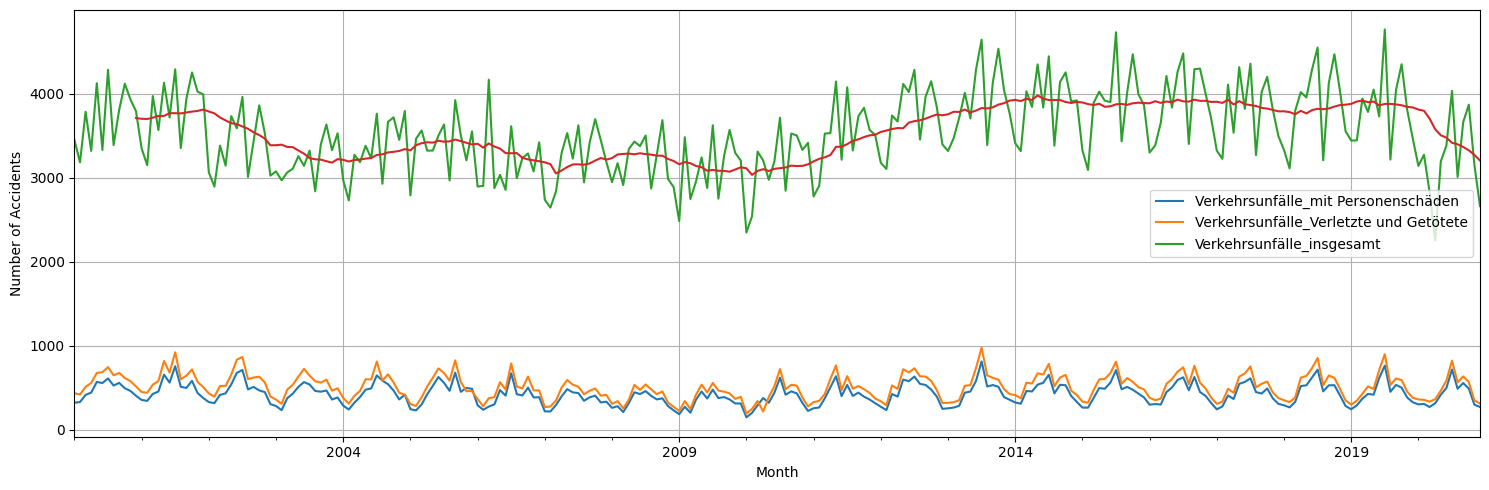

In [46]:
pivot_Wert['Verkehrsunfälle_mit Personenschäden'].plot(figsize=(15, 5), legend=True)
pivot_Wert['Verkehrsunfälle_Verletzte und Getötete'].plot(figsize=(15, 5), legend=True)
pivot_Wert['Verkehrsunfälle_insgesamt'].plot(figsize=(15, 5), legend=True)
pivot_Wert['Verkehrsunfälle_insgesamt'].rolling(window=12).mean().plot(figsize=(15, 5), legend=False)

plt.xlabel('Month')
plt.ylabel('Number of Accidents')
plt.grid(True)
plt.tight_layout()

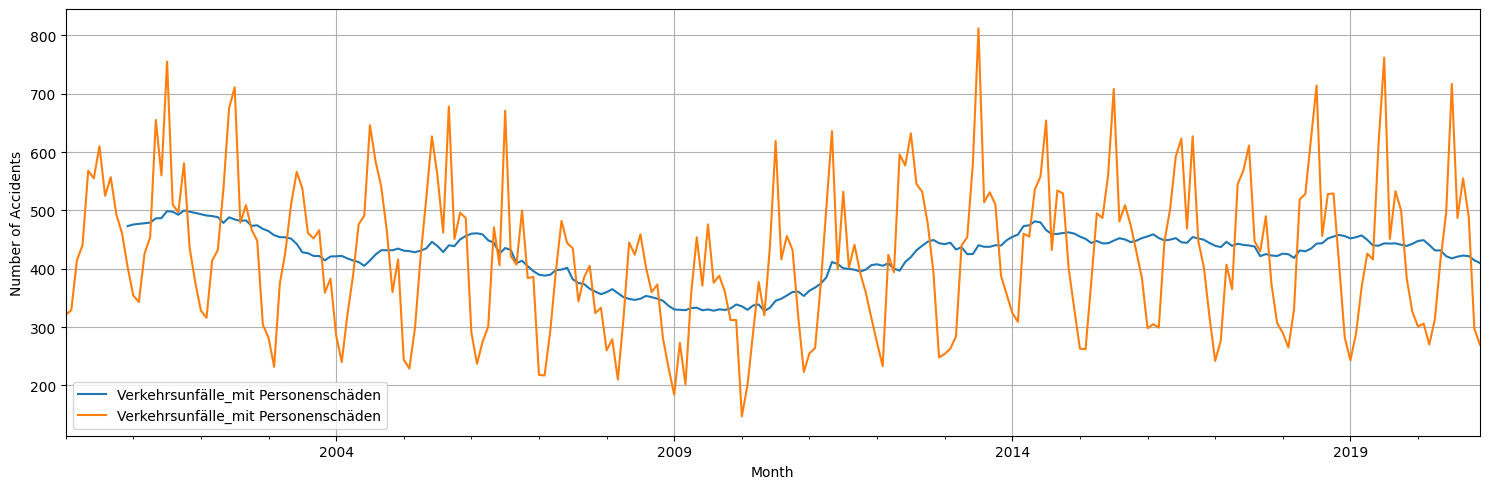

In [47]:
pivot_Wert['Verkehrsunfälle_mit Personenschäden'].rolling(window=12).mean().plot(figsize=(15, 5), legend=True)
pivot_Wert['Verkehrsunfälle_mit Personenschäden'].plot(figsize=(15, 5), legend=True)

plt.xlabel('Month')
plt.ylabel('Number of Accidents')
plt.grid(True)
plt.tight_layout()

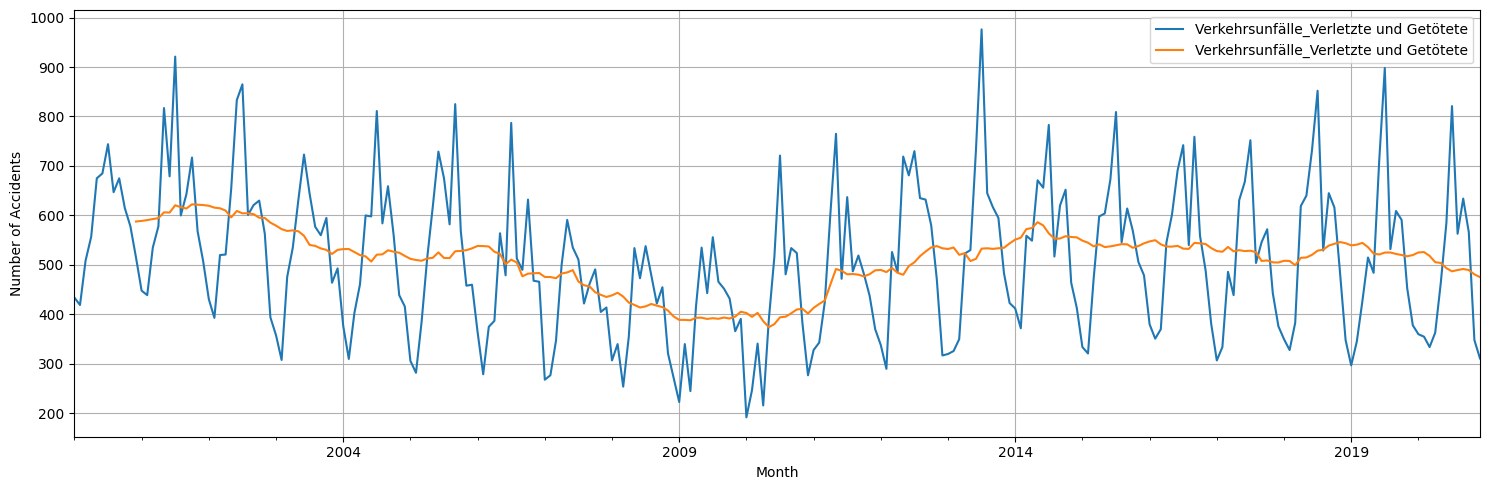

In [48]:
pivot_Wert['Verkehrsunfälle_Verletzte und Getötete'].plot(figsize=(15, 5), legend=True)
pivot_Wert['Verkehrsunfälle_Verletzte und Getötete'].rolling(window=12).mean().plot(figsize=(15, 5), legend=True)
plt.xlabel('Month')
plt.ylabel('Number of Accidents')
plt.grid(True)
plt.tight_layout()

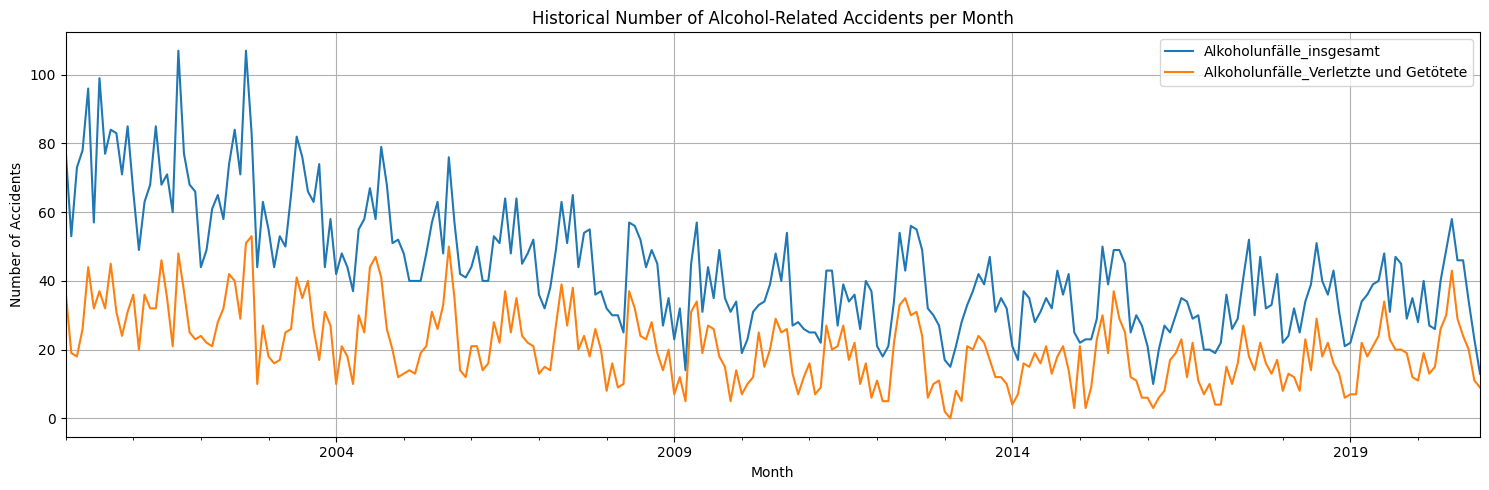

In [49]:
pivot_Wert['Alkoholunfälle_insgesamt'].plot(figsize=(15, 5), legend=True)
pivot_Wert['Alkoholunfälle_Verletzte und Getötete'].plot(figsize=(15, 5), legend=True)
plt.title('Historical Number of Alcohol-Related Accidents per Month')
plt.xlabel('Month')
plt.ylabel('Number of Accidents')
plt.grid(True)
plt.tight_layout()

<Axes: xlabel='MONAT'>

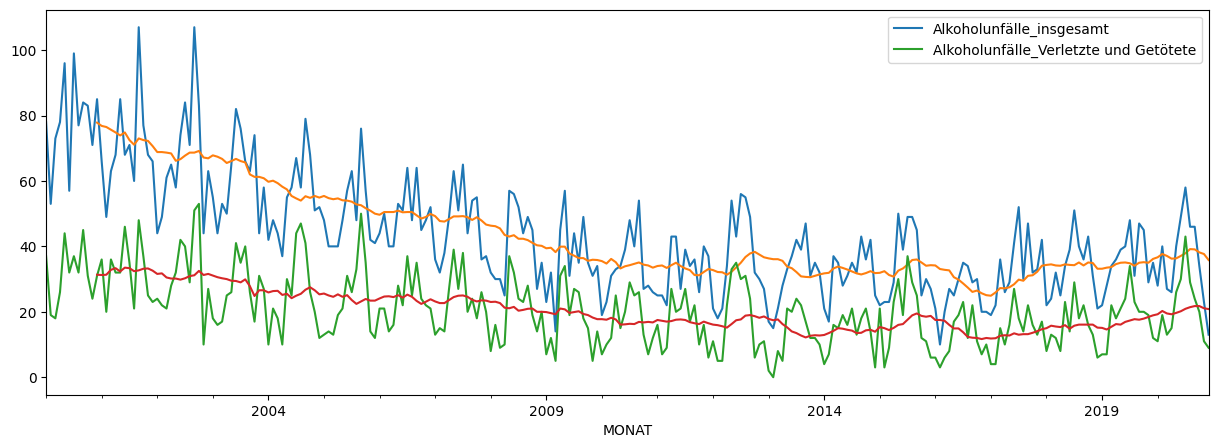

In [50]:

pivot_Wert['Alkoholunfälle_insgesamt'].plot(figsize=(15, 5), legend=True)
pivot_Wert['Alkoholunfälle_insgesamt'].rolling(window=12).mean().plot( legend=False)
pivot_Wert['Alkoholunfälle_Verletzte und Getötete'].plot( legend=True)
pivot_Wert['Alkoholunfälle_Verletzte und Getötete'].rolling(window=12).mean().plot( legend=False)

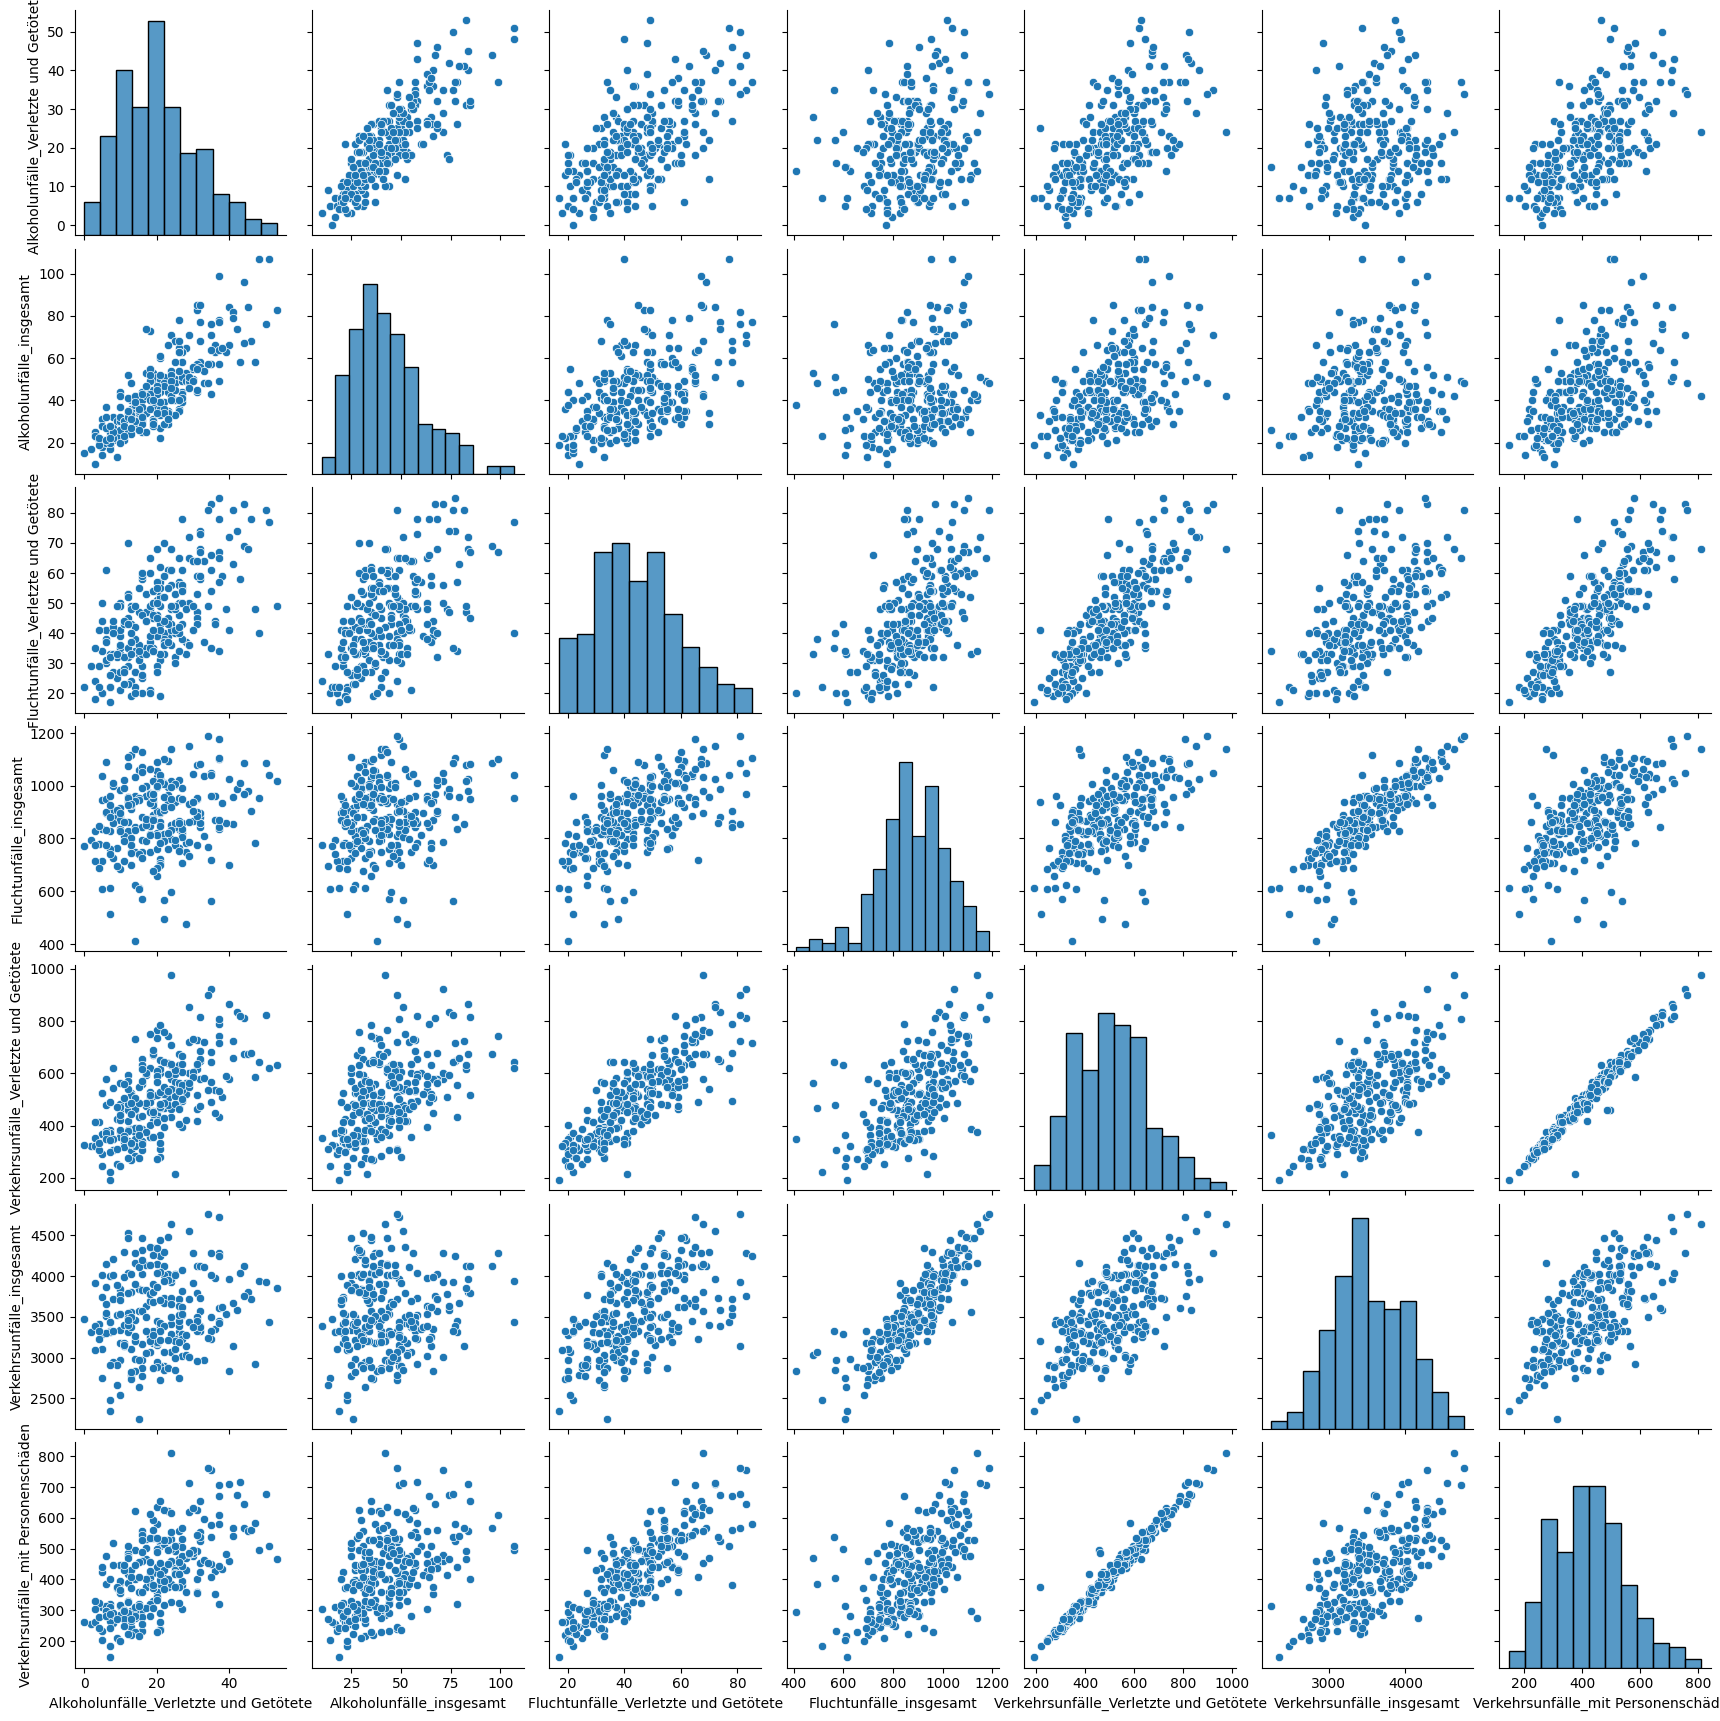

In [51]:
sns.pairplot(pivot_Wert, diag_kind='hist')

In [52]:
pivot_Wert.corr()

,Alkoholunfälle_Verletzte und Getötete,Alkoholunfälle_insgesamt,Fluchtunfälle_Verletzte und Getötete,Fluchtunfälle_insgesamt,Verkehrsunfälle_Verletzte und Getötete,Verkehrsunfälle_insgesamt,Verkehrsunfälle_mit Personenschäden
Alkoholunfälle_Verletzte und Getötete,1.000000,0.827854,0.615693,0.226250,0.623204,0.148816,0.605607
Alkoholunfälle_insgesamt,0.827854,1.000000,0.535236,0.231376,0.529470,0.141663,0.487756
Fluchtunfälle_Verletzte und Getötete,0.615693,0.535236,1.000000,0.592448,0.825541,0.557021,0.818332
Fluchtunfälle_insgesamt,0.226250,0.231376,0.592448,1.000000,0.605159,0.861219,0.604825
Verkehrsunfälle_Verletzte und Getötete,0.623204,0.529470,0.825541,0.605159,1.000000,0.661860,0.982394
Verkehrsunfälle_insgesamt,0.148816,0.141663,0.557021,0.861219,0.661860,1.000000,0.657163
Verkehrsunfälle_mit Personenschäden,0.605607,0.487756,0.818332,0.604825,0.982394,0.657163,1.000000


## Preprocessing

In [57]:
df_train = df[(df['MONATSZAHL'] == 'Alkoholunfälle') & (df['AUSPRAEGUNG'] == 'insgesamt') & (df['JAHR'] <= 2020)]
df_test = df[(df['MONATSZAHL'] == 'Alkoholunfälle') & (df['AUSPRAEGUNG'] == 'insgesamt') & (df['JAHR'] == 2021)]
df_train.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
MONAT,,,,,,,,
2020-01-01,Alkoholunfälle,insgesamt,2020,28.0,22.0,-20.00,27.27,37.0
2020-02-01,Alkoholunfälle,insgesamt,2020,40.0,28.0,42.86,42.86,38.0
2020-03-01,Alkoholunfälle,insgesamt,2020,27.0,34.0,-32.50,-20.59,37.0
2020-04-01,Alkoholunfälle,insgesamt,2020,26.0,36.0,-3.70,-27.78,36.0
2020-05-01,Alkoholunfälle,insgesamt,2020,40.0,39.0,53.85,2.56,36.0


In [58]:
df_train.columns

Index(['MONATSZAHL', 'AUSPRAEGUNG', 'JAHR', 'WERT', 'VORJAHRESWERT',
       'VERAEND_VORMONAT_PROZENT', 'VERAEND_VORJAHRESMONAT_PROZENT',
       'ZWOELF_MONATE_MITTELWERT'],
      dtype='object')

In [59]:
df_train = df_train.drop(['MONATSZAHL', 'AUSPRAEGUNG','JAHR', 'VORJAHRESWERT',
       'VERAEND_VORMONAT_PROZENT', 'VERAEND_VORJAHRESMONAT_PROZENT',
       'ZWOELF_MONATE_MITTELWERT'], axis=1)

In [60]:
df_test = df_test.drop(['MONATSZAHL', 'AUSPRAEGUNG','JAHR', 'VORJAHRESWERT',
       'VERAEND_VORMONAT_PROZENT', 'VERAEND_VORJAHRESMONAT_PROZENT',
       'ZWOELF_MONATE_MITTELWERT'], axis=1)

In [61]:
df_train.head()

,WERT
MONAT,
2020-01-01,28.0
2020-02-01,40.0
2020-03-01,27.0
2020-04-01,26.0
2020-05-01,40.0


In [63]:
df_train.sort_index(inplace=True)
df_test.sort_index(inplace=True)

<Axes: xlabel='MONAT'>

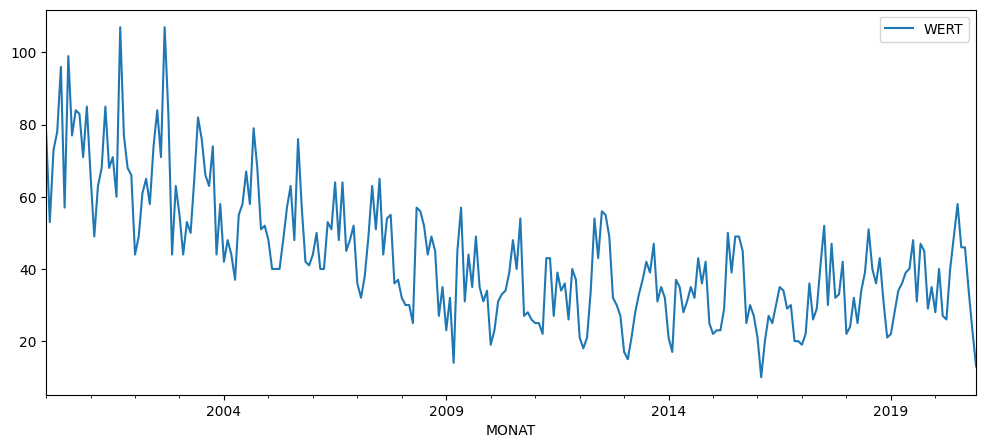

In [64]:
df_train.plot(figsize=(12,5))

## Model Implementation 

/Users/nullhawk/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/nullhawk/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


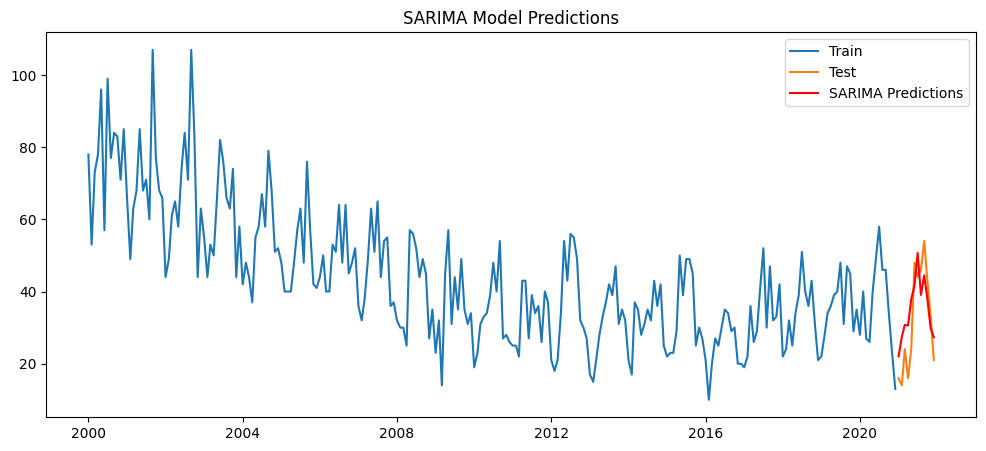

In [73]:

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit the SARIMA model
sarima_model = SARIMAX(df_train['WERT'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit(disp=False)

# Make predictions
df_test['SARIMA_Predictions'] = sarima_fit.predict(start=df_test.index[0], end=df_test.index[-1], dynamic=False)

# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(df_train['WERT'], label='Train')
plt.plot(df_test['WERT'], label='Test')
plt.plot(df_test['SARIMA_Predictions'], label='SARIMA Predictions', color='red')
plt.legend(loc='best')
plt.title('SARIMA Model Predictions')
plt.show()

Mean Absolute Error (MAE): 8.231475522595176
Mean Squared Error (MSE): 80.58646670989513
Root Mean Squared Error (RMSE): 8.976996530571633


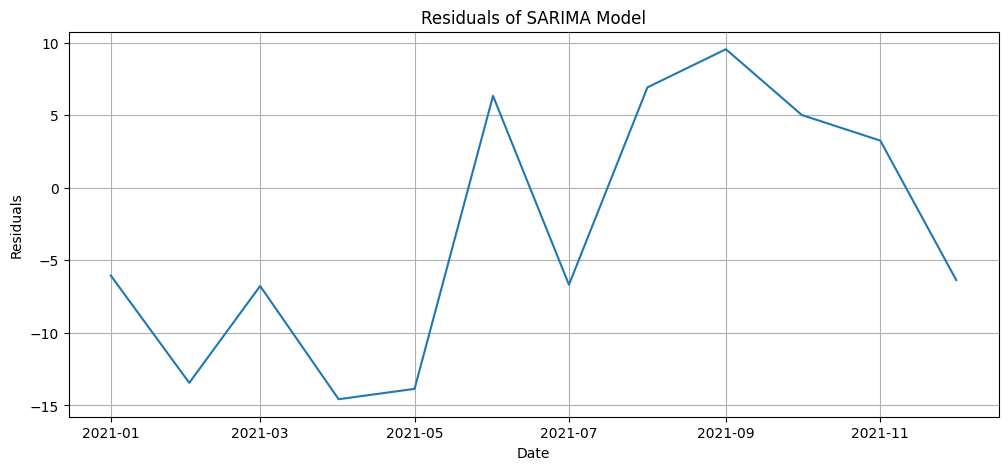

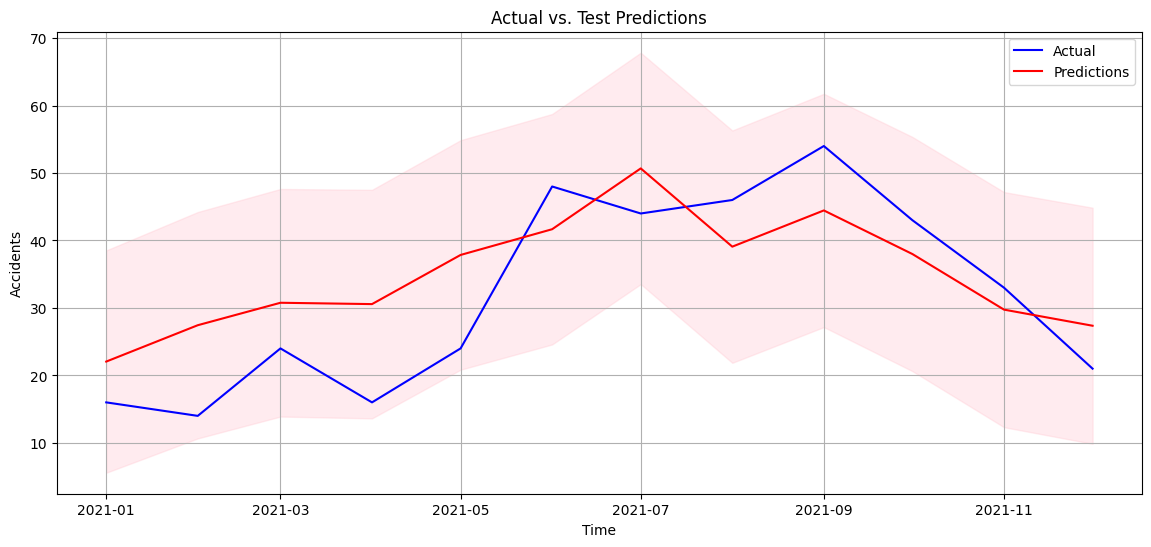

In [79]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate metrics
mae = mean_absolute_error(df_test['WERT'], df_test['SARIMA_Predictions'])
mse = mean_squared_error(df_test['WERT'], df_test['SARIMA_Predictions'])
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Ensure the lengths of the arrays match
common_index = df_test.index.intersection(df_test['SARIMA_Predictions'].index)
residuals = df_test.loc[common_index, 'WERT'].values - df_test.loc[common_index, 'SARIMA_Predictions'].values

# Plot residuals
plt.figure(figsize=(12, 5))
plt.plot(common_index, residuals)
plt.title('Residuals of SARIMA Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# Plot actual vs. predicted values with confidence intervals
plt.figure(figsize=(14, 6))
plt.plot(df_test.index, df_test['WERT'], label='Actual', color='blue')
plt.plot(df_test.index, df_test['SARIMA_Predictions'], label='Predictions', color='red')
conf_int = sarima_fit.get_forecast(steps=len(df_test)).conf_int()
plt.fill_between(df_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Time')
plt.ylabel('Accidents')
plt.legend()
plt.title('Actual vs. Test Predictions')
plt.grid(True)
plt.show()


### Saving

In [82]:
np.savetxt("data/test_point.csv", df_test.index, delimiter=',' , fmt='%d')

In [88]:
import joblib
joblib.dump(sarima_fit, 'checkpoints/sarima.pkl')

['checkpoints/sarima.pkl']

## Testing out the model after saving

In [84]:
with open("data/test_point.csv", "r") as f:
    test = np.loadtxt(f, delimiter=',')

In [85]:
print(test)

[1.6094592e+18 1.6121376e+18 1.6145568e+18 1.6172352e+18 1.6198272e+18
 1.6225056e+18 1.6250976e+18 1.6277760e+18 1.6304544e+18 1.6330464e+18
 1.6357248e+18 1.6383168e+18]


In [97]:
bt1= joblib.load('checkpoints/sarima_model.pkl')

In [91]:
def predict_for_date(year, month, model=sarima_fit, data=df_train):
    target_date = pd.Timestamp(year=year, month=month, day=1)
    last_known_date = data.index[-1]
    
    months_diff = (target_date.year - last_known_date.year) * 12 + target_date.month - last_known_date.month
    if months_diff > 0:
        prediction = model.get_forecast(steps=months_diff).predicted_mean.iloc[-1]
    else:
        prediction = data.loc[target_date.strftime('%Y-%m-%d')] if target_date in data.index else None
    
    return prediction

In [92]:
year = 2021
month = 1
predict_for_date(year, month)

np.float64(22.04806787285667)

In [93]:
test_dates = pd.to_datetime(test, unit='ns')

predictions = []

for test_date in test_dates:
    year = test_date.year
    month = test_date.month
    prediction = predict_for_date(year, month)
    predictions.append(prediction)

In [94]:
predictions

[np.float64(22.04806787285667),
 np.float64(27.438504436729882),
 np.float64(30.76673481901078),
 np.float64(30.568512480261965),
 np.float64(37.85502775192042),
 np.float64(41.66823644091678),
 np.float64(50.68148574977177),
 np.float64(39.08318055824796),
 np.float64(44.45292626046266),
 np.float64(37.98673891814615),
 np.float64(29.749976766339017),
 np.float64(27.36043210470319)]

In [95]:
df_train.index[-1]

Timestamp('2020-12-01 00:00:00')

In [96]:
df_train.to_csv('data/df_train.csv')